In [15]:
import torch
from sentence_transformers import SentenceTransformer
from transformers import MPNetTokenizer, MPNetModel
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import os
import numpy as np

model_path = '/data/gunsbrother/prjs/ltvu/everything/sbert_finetune/outputs/batch/2024-06-07/17-03-43/lit/103204/checkpoints/step=3834-nlq_R5@0.3=0.0000.ckpt'
model = SentenceTransformer('all-mpnet-base-v2').cuda().eval()
model.load_state_dict(
    {k.replace('model.model.', '0.auto_model.'): v for k, v in torch.load(model_path)['state_dict'].items()},
    strict=False
)

_IncompatibleKeys(missing_keys=['0.auto_model.pooler.dense.weight', '0.auto_model.pooler.dense.bias'], unexpected_keys=[])

In [16]:
p_caps_dir = Path('/data/gunsbrother/prjs/ltvu/everything/sbert_finetune/data/captions/llava-v1.6-34b/global')
p_caps = list(p_caps_dir.glob('*.json'))

annotations = json.loads(Path(os.path.join('/data/soyeonhong/GroundVQA/data/unified/annotations.NLQ_train.json')).read_text())
valid_video_id = [annotation['video_id'] for annotation in annotations]

In [17]:
cos_sims_all = []
cos_sim_tmp = []
for p_cap in p_caps:
    if p_cap.stem in valid_video_id:

        cap_data = json.load(p_cap.open())['answers']
        caps = [entry[2] for entry in cap_data]

        embeddings = model.encode(caps)

        cos_sim = embeddings @ embeddings.T
        
        adjacent_cos_sim = []
        for idx in range(1, len(embeddings) - 1):
            adjacent_cos_sim.append(cos_sim[idx, idx+1])
            cos_sim_tmp.append(cos_sim[idx, idx+1])

        cos_sims_all.append(np.mean(np.array(adjacent_cos_sim)))

np.mean(np.array(cos_sims_all))

0.6389749

In [18]:
# histplot cos_sim_tmp
annotations_val = json.loads(Path(os.path.join('/data/soyeonhong/GroundVQA/data/unified/annotations.NLQ_val.json')).read_text())
valid_video_id_val = [annotation['video_id'] for annotation in annotations_val]

cos_sims_all_val = []
cos_sim_tmp_val = []
for p_cap in p_caps:
    if p_cap.stem in valid_video_id_val:

        cap_data = json.load(p_cap.open())['answers']
        caps = [entry[2] for entry in cap_data]

        embeddings = model.encode(caps)

        cos_sim = embeddings @ embeddings.T
        
        adjacent_cos_sim = []
        for idx in range(1, len(embeddings) - 1):
            adjacent_cos_sim.append(cos_sim[idx, idx+1])
            cos_sim_tmp_val.append(cos_sim[idx, idx+1])

        cos_sims_all.append(np.mean(np.array(adjacent_cos_sim)))

np.mean(np.array(cos_sims_all))

0.6347218

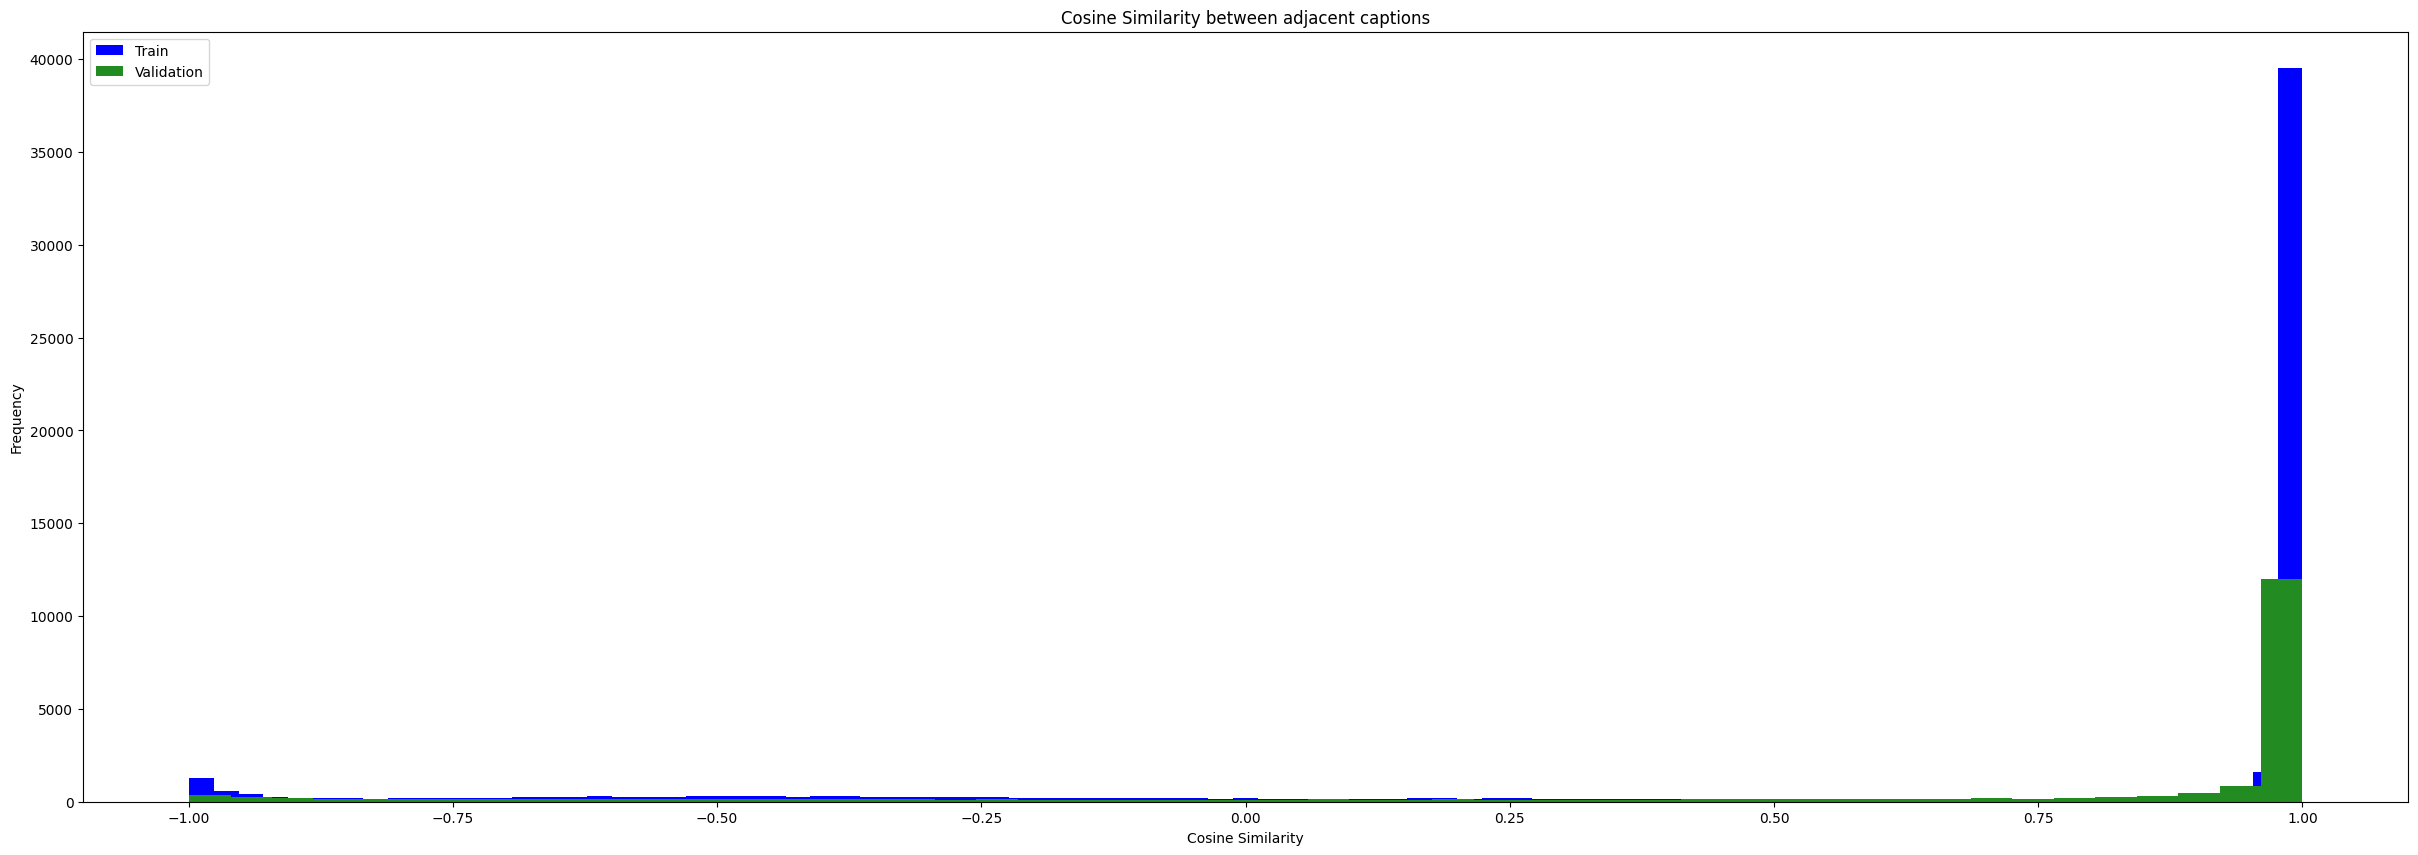

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 10))
plt.hist(cos_sim_tmp, bins='auto', color='blue', label='Train')
plt.hist(cos_sim_tmp_val, bins='auto', color='forestgreen', label='Validation')
plt.title('Cosine Similarity between adjacent captions')
plt.legend()
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()